In [1]:
# импортируем библиотеки, классы и функции
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# загружаем данные
data = pd.read_csv('Data/Response.csv', sep=';')
data.head(3)

,mortgage,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet,perloan,savings,atm_user,markpl,age,cus_leng,response
0,No,No,No,No,No,No,No,No,No,No,No,18.0,less than 3 years,No
1,Yes,Yes,NaN,NaN,Yes,No,NaN,NaN,NaN,Yes,No,18.0,NaN,Yes
2,Yes,Yes,NaN,Yes,No,No,No,No,No,No,Yes,NaN,from 3 to 7 years,Yes


In [3]:
# создаем массив меток и массив признаков
y = data.pop('response')

# создаем списки категориальных 
# и количественных столбцов
categorical_features = data.select_dtypes(
    include='object').columns.tolist()
numeric_features = data.select_dtypes(
    exclude='object').columns.tolist()

# создаем трансформеры
numeric_transformer_logreg = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numeric_transformer_boost = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, 
                             handle_unknown='ignore'))
])

# сопоставляем трансформеры спискам переменных 
# для логистической регрессии
preprocessor_logreg = ColumnTransformer([
    ('num', numeric_transformer_logreg, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# сопоставляем трансформеры спискам переменных 
# для градиентного бустинга
preprocessor_boost = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_boost, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# формируем итоговый конвейер
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor_logreg),
    ('logreg', LogisticRegression(solver='lbfgs', 
                                  max_iter=400))])
pipe_boost = Pipeline([
    ('preprocessor', preprocessor_boost),
    ('boost', GradientBoostingClassifier(
        random_state=42))
])  

In [4]:
# пишем функцию, которая строит графики 
# по результатам функции learning_curve()
def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        axes=None, 
                        ylim=None, 
                        cv=None,
                        n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Строит 3 графика: кривые обучения и валидации, кривую зависимости между 
    объемом обучающих данных и временем обучения, кривую зависимости между
    временем обучения и оценкой качества.

    Параметры
    ----------
    estimator : модель машинного обучения для проверки.
    title : заголовок диаграммы.
    X : массив признаков.
    y : массив меток.
    axes : задаем область рисования (Axes) для построения кривых.
    ylim : задает минимальное и максимальное значение по оси y.
    cv : стратегия перекрестной проверки.
    n_jobs : количество используемых ядер процессора.
    train_sizes : абсолютное или относительное количество наблюдений.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Обучающие наблюдения")
    axes[0].set_ylabel("Оценка")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, 
                       scoring='roc_auc', n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # строим кривые обучения и валидации
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Средняя оценка на обуч. блоках")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Средняя оценка на тест. блоках")
    axes[0].legend(loc="best")

    # строим график зависимости между объемом 
    # обучающих данных и временем обучения
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Обучающие наблюдения")
    axes[1].set_ylabel("Время обучения")
    axes[1].set_title("Масштабируемость модели")

    # строим график зависимости между временем 
    # обучения и оценкой качества
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Время обучения")
    axes[2].set_ylabel("Оценка")
    axes[2].set_title("Качество модели")

    return plt

/Users/artemgruzdev/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


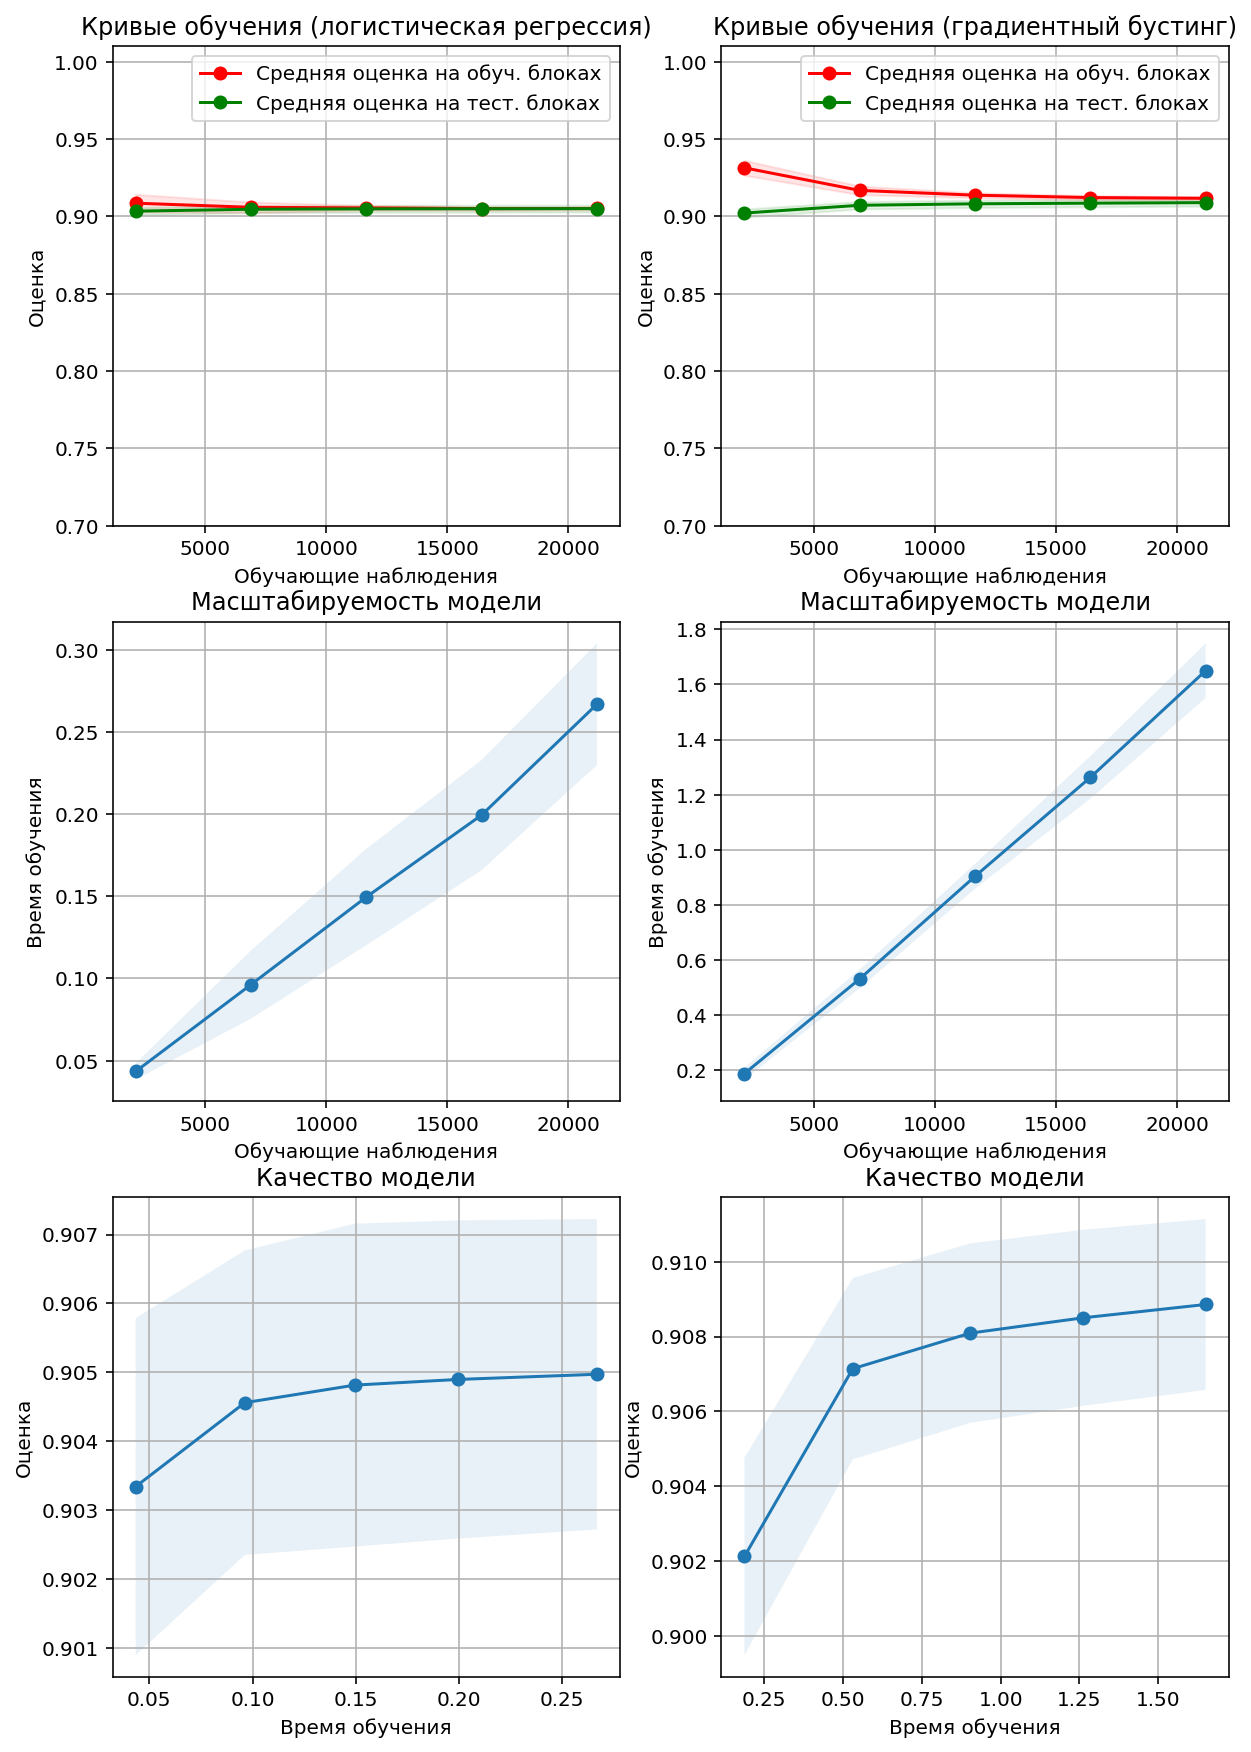

In [5]:
# задаем сетку и размеры графиков
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
# задаем стратегию перекрестной проверки
cv = ShuffleSplit(n_splits=20, test_size=0.3, random_state=42)

# задаем заголовок
title = "Кривые обучения (логистическая регрессия)"
# строим графики для логистической регрессии
plot_learning_curve(pipe_logreg, title, data, y, axes=axes[:, 0], 
                    ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

# задаем заголовок
title = "Кривые обучения (градиентный бустинг)"
# строим графики для градиентного бустинга
plot_learning_curve(pipe_boost, title, data, y, axes=axes[:, 1], 
                    ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

# выводим графики
plt.show()

In [6]:
# загружаем данные
data = pd.read_csv('Data/StateFarm_missing.csv', sep=';')
data.head(3)

,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Response
0,2763.519279,Basic,Bachelor,Employed,F,56274.0,NaN,32.0,5.0,NaN,1.0,No
1,NaN,NaN,Bachelor,Unemployed,F,0.0,NaN,13.0,42.0,NaN,NaN,No
2,NaN,NaN,NaN,Employed,F,48767.0,108.0,NaN,38.0,0.0,NaN,No


In [7]:
# формируем массив меток и массив признаков
y = data.pop('Response')

# создаем списки количественных 
# и категориальных столбцов
cat_features = data.select_dtypes(
    include='object').columns.tolist()
num_features = data.select_dtypes(
    exclude='object').columns.tolist()

# сопоставляем трансформеры спискам переменных 
# для логистической регрессии
preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer_logreg, num_features),
    ('cat', categorical_transformer, cat_features)
])

# сопоставляем трансформеры спискам переменных 
# для градиентного бустинга
preprocessor_bst = ColumnTransformer([
    ('num', numeric_transformer_boost, num_features),
    ('cat', categorical_transformer, cat_features)
])

# формируем итоговый конвейер
pipe_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('logreg', LogisticRegression(solver='lbfgs', 
                                  max_iter=400))
])

pipe_bst = Pipeline([
    ('preprocessor', preprocessor_bst),
    ('boost', GradientBoostingClassifier(
        random_state=42))
])  

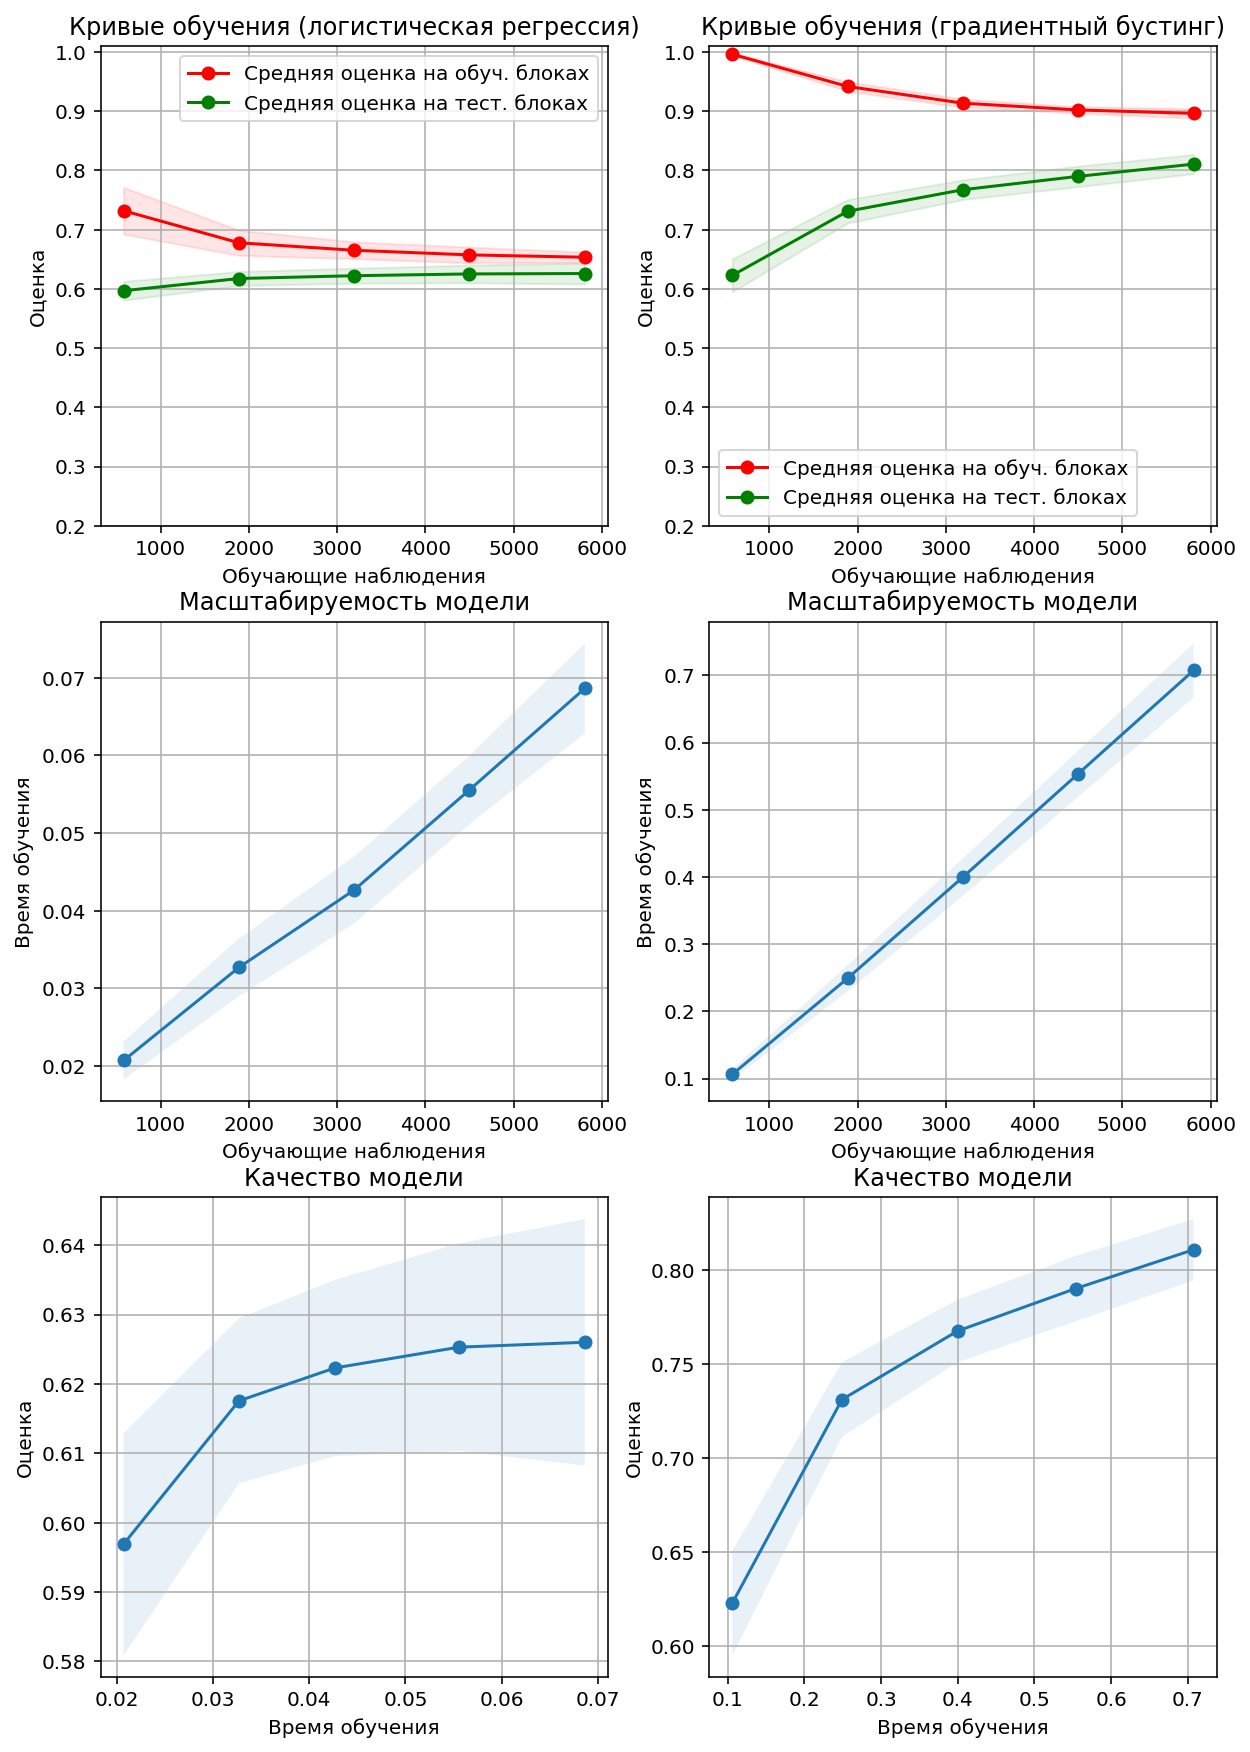

In [8]:
# задаем сетку и размеры графиков
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
# задаем заголовок
title = "Кривые обучения (логистическая регрессия)"
# строим графики для логистической регрессии
plot_learning_curve(pipe_lr, title, data, y, axes=axes[:, 0], 
                    ylim=(0.2, 1.01),
                    cv=cv, n_jobs=4)

# задаем заголовок
title = "Кривые обучения (градиентный бустинг)"
# строим графики для градиентного бустинга
plot_learning_curve(pipe_bst, title, data, y, axes=axes[:, 1], 
                    ylim=(0.2, 1.01),
                    cv=cv, n_jobs=4)

# выводим графики
plt.show()

In [9]:
# импортируем класс KFold
from sklearn.model_selection import KFold

# пишем упрощенную версию plot_learning_curve()
def plot_learning_curve_simple(est, X, y):
    # получаем наборы для обучения, значения метрик
    training_set_size, train_scores, test_scores = learning_curve(
        est, X, y, train_sizes=np.linspace(.1, 1, 10), scoring='roc_auc',
        cv=KFold(20, shuffle=True, random_state=1))
    # извлекаем имя последнего этапа итогового конвейера -
    # название модели машинного обучения
    estimator_name = est.steps[-1][0]
    # строим кривые обучения и валидации
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--',
                    label="обучение - " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-',
             label="тест - " + estimator_name, c=line[0].get_color())
    # задаем координатную сетку
    plt.grid()
    # подписываем ось x
    plt.xlabel("Размер обучающего набора")
    # подписываем ось y
    plt.ylabel("AUC")
    # задаем пределы значений оси y
    plt.ylim(0, 1.1)
    # задаем расположение легенды
    plt.legend(loc=(0, 1.05), fontsize=11)

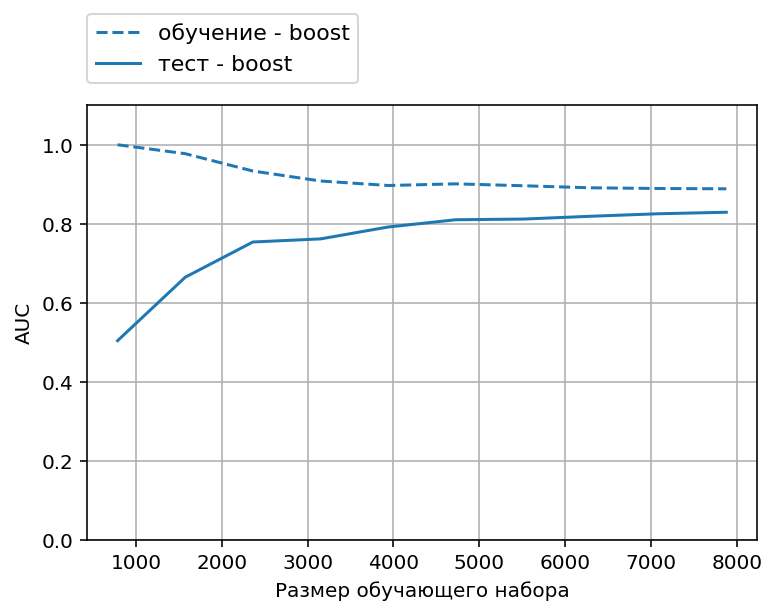

In [10]:
# применяем упрощенную версию plot_learning_curve()
plot_learning_curve_simple(pipe_bst, data, y)